In [4]:
%cd C:\Users\tanak\study\参考書\pytorchによる発展ディープラーニング\pytorch_advanced-master\2_objectdetection

C:\Users\tanak\study\参考書\pytorchによる発展ディープラーニング\pytorch_advanced-master\2_objectdetection


## 20. 物体検出(SSD)
物体検出とは、1枚の画像中に含まれている複数の物体に対して、物体の領域と物体名を特定する手法のことである。  
出力される情報は、
- 画像のどこに物体が存在するかを示すバウンディングボックスの位置と大きさの情報
- 各バウンディングボックスが何の物体であるかを示すラベル情報
- 信頼度(confidence)

である。  

### SSD
SSDによる物体検出では、入力画像の大きさを300×300ピクセルにリサイズするSSD300と、512×512ピクセルにするSSD512がある。  
また、バウンディングボックスを求める際に**デフォルトボックス**と呼ばれる定型的な長方形を用意しておき、  
どのように変形させればバウンディングボックスになるかの情報を出力させる。  
デフォルトボックスの情報が、$(cx_d,cy_d,w_d,h_d)$であった場合($cx_d,cy_d$は中心座標、$w_d,h_d$は横・縦の幅)、  
オフセットの情報は$(\Delta cx,\Delta cy,\Delta w,\Delta h)$となり、バウンディングボックスの情報は、
$$
cx=cx_d+0.1\Delta cx×w_d\\
cx=cy_d+0.1\Delta cy×h_d\\
w=w_d×\exp{(0.2\Delta w)}\\
h=h_d×\exp{(0.2\Delta h)}
$$

SSD300の場合、様々なアスペクト比の8732個のデフォルトボックスを用意する(各出力に対してDBoxを用意するため)。  
クラス数が21(VOCデータセット)の場合、各デフォルトボックスに対しオフセットの4変数と信頼度が計算されるので、  
8732×(4+21)=218300個の情報を出力させる。  
信頼度の高いものを上位から取り出し(SSD300では200個)、重なりの大きいものは信頼度の高いものにまとめる。  
信頼度にしきい値を定め、最終的に高い信頼度のバウンディングボックスを残す。

#### データの準備

#### SSDネットワークモデル
SSDの主なサブネットワークは、
- vgg
- extra
- loc
- conf

の4つとなる。

#### vgg
VGG16をベースとしている。出力層とは別に10回の畳み込みを受けたデータが別途抜き出され、L2Norm層で正規化され出力される。

In [4]:
import numpy as np

import torch
from torch import nn

def make_vgg():
    layers = []
    in_channels = 3
    
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'MC',
           512, 512, 512, 'M', 512, 512, 512]
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6, nn.ReLU(inplace=True),
               conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

#### extra
畳み込みを8回行う。2回畳み込むごとにそれを出力する(合計4つ)。  
各特徴マップの大きさが異なり、様々な大きさの物体を想定した特徴量を得ることができる。  
特徴量マップの大きい(細かい)ものは、畳み込みの回数が少ないので、SSDでは小さな領域の特徴量抽出・物体検出が苦手であり、  
画像内の小さな物体の検出精度が画像内の大きな物体の検出精度よりも低くなる傾向がある。

In [5]:
def make_extras():
    layers = []
    in_channels = 1024
    
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]
    
    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    return nn.ModuleList(layers)

In [6]:
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


#### loc、conf
vgg、extraで6つの出力が得られたが、  
locでは各出力に1回ずつ畳み込み処理を実施し、オフセット情報を出力する。  
また、confでは各出力に1回ずつ畳み込み処理を実施し、各クラスの信頼度を出力する。

In [7]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4,6,6,6,4,4]):
    
    loc_layers = []
    conf_layers = []
    
    # VGG22層目　conv4_3(source1)に対する畳み込み
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0] * num_classes, kernel_size=3, padding=1)]
    
    # VGG最終層(source2)に対する畳み込み
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * num_classes, kernel_size=3, padding=1)]
    
    # extraのsource3に対する畳み込み
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2] * num_classes, kernel_size=3, padding=1)]
    
    # extraのsource4に対する畳み込み
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3] * num_classes, kernel_size=3, padding=1)]
    
    # extraのsource5に対する畳み込み
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4] * num_classes, kernel_size=3, padding=1)]
    
    # extraのsource6に対する畳み込み
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5] * num_classes, kernel_size=3, padding=1)]
    
    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

In [8]:
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


#### L2Norm
チャネル方向に対して正規化を行う。  
今回の場合は、L2Norm層への入力は512チャネル×38×38であるので、38×38=1444のセルについて512チャネルに渡って正規化を行う。  
また、正規化した512チャネルのテンソルに対して、チャネルごとに係数を掛け合わせる。この係数も学習させるパラメータである。

In [9]:
import torch.nn.init as init

class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale
        self.reset_parameters()
        self.eps = 1e-10
    
    def reset_parameters(self):
        init.constant_(self.weight, self.scale)
    
    def forward(self, x):
        # 正規化
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)
        
        # 係数をかける
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x
        
        return out

#### デフォルトボックス
それぞれの特徴マップに4または6種類のDBoxを用意する。  
4種類の場合は小さい正方形、大きい正方形、1:2または2:1の長方形、そして6種類の場合はこれに加え1:3または3:1の長方形を用意する。

In [10]:
from itertools import product as product
from math import sqrt as sqrt
import pandas as pd

class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()
        
        self.image_size = cfg['input_size']
        self.feature_maps = cfg['feature_maps']
        self.num_priors = cfg['feature_maps']
        self.steps = cfg['steps']
        self.min_sizes = cfg['min_sizes']
        self.max_sizes = cfg['max_sizes']
        self.aspect_ratios = cfg['aspect_ratios']
    
    def make_dbox_list(self):
        mean = []
        
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.steps[k]
                
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k
                
                # アスペクト比1 小さい正方形
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]
                
                # アスペクト比1 大きい正方形
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]
                
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k+sqrt(ar)]
        
        output = torch.Tensor(mean).view(-1, 4)
        output.clamp_(max=1, min=0)
        
        return output

In [11]:
ssd_cfg = {
    'num_classes': 21,
    'input_size': 300,
    'bbox_aspect_num': [4,6,6,6,4,4],
    'feature_maps': [38,19,10,5,3,1],
    'steps': [8,16,32,64,100,300],
    'min_sizes': [30,60,111,162,213,264],
    'max_sizes': [60,111,162,213,264,315],
    'aspect_ratios': [[2],[2,3],[2,3],[2,3],[2],[2]]
}

dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,1.000000
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


#### クラスSSD

In [12]:
class SSD(nn.Module):
    def __init__(self, phase, cfg):
        super(SSD, self).__init__()
        
        self.phase = phase
        self.num_classes = cfg['num_classes']
        
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(cfg['num_classes'], cfg['bbox_aspect_num'])
        
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()
        
        if phase == 'inference':
            self.detect = Detect()

In [13]:
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

**順伝搬関数の実装**

decode関数  
DBOX=$(cx_d,cy_d,w_d,h_d)$と、SSDモデルから求めたオフセット情報loc=$(\Delta cx, \Delta cy, \Delta w, \Delta h)$を使用し、  
バウンディングボックス(BBox)の座標を作成する関数  
BBOXの情報は、  
$$
cx=cx_d+0.1\Delta cx×w_d\\
cx=cy_d+0.1\Delta cy×h_d\\
w=w_d×\exp{(0.2\Delta w)}\\
h=h_d×\exp{(0.2\Delta h)}
$$

と計算される。

In [14]:
def decode(loc, dbox_list):
    
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    
    # [cx ,cy, width, height] -> [xmin, ymin, xmax, ymax]
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    
    return boxes

#### Non-Maximum Suppression
1つの物体に対して、1つのBBoxのみを残す処理を行う処理。  
BBox同士の被っている面積が閾値以上である場合には、同じ物体への冗長なBBoxと判定する。  
そして、確信度が一番大きなBBoxのみを残す処理を行う。

In [15]:
def nm_supression(boxes, scores, overlap=0.45, top_k=200):
    
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()
    
    v, idx = scores.sort(0)
    
    idx = idx[-top_k:]
    
    while idx.numel() > 0:
        i = idx[-1]
        
        keep[count] = i
        count += 1
        
        if idx.size(0) == 1:
            break
        
        idx = idx[:-1]
        
        # keepに格納したBBoxと被りの大きいBBoxを抽出し除去する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)
        
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, min=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, min=y2[i])
        
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)
        
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1
        
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)
        
        inter = tmp_w*tmp_h
        
        rem_areas = torch.index_select(area, 0, idx)
        union = (rem_areas - inter) + area[i]
        IoU = inter / union
        
        idx = idx[IoU.le(overlap)]
    
    return keep, count

#### クラスDetect

In [16]:
import torch.nn.functional as F
from torch.autograd import Function

class Detect(Function):
    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh
        self.top_k = top_k
        self.nms_thresh = nms_thresh
    
    def forward(self, loc_data, conf_data, dbox_list):
        num_batch = loc_data.size(0)
        num_dbox = loc_data.size(1)
        num_classes = conf_data.size(2)
        
        conf_data = self.softmax(conf_data)
        
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)
        
        conf_preds = conf_data.transpose(2, 1)
        
        for i in range(num_batch):
            decoded_boxes = decode(loc_data[i], dbox_list)
            conf_scores = conf_preds[i].clone()
            
            for cl in range(1, num_classes):
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                scores = conf_scores[cl][c_mask]
                
                if scores.nelement() == 0:
                    continue
                
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                
                boxes = decoded_boxes[l_mask].view(-1, 4)
                
                ids, count = nm_suppression(boxes, scores, self.nms_thresh, self.top_k)
                
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1), boxes[ids[:count]]), 1)
        return output

In [17]:
# SSDクラスを作成する


class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納

        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                sources.append(x)

        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 学習時
            return output
            # 返り値は(loc, conf, dbox_list)のタプル




In [95]:
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

### 損失関数
#### jaccard係数
正解BBoxと近いDBoxの抽出時には**jaccard係数**を使用する。  
$$
正解BBoxとDBoxのjaccard係数=\frac{正解BBox\cap DBox}{正解BBox\cup DBox}
$$

jaccard係数が0.5以上となる正解BBoxを持たないDBoxの場合、  
そのDBoxをNegative DBoxとし、そのDBoxの予測結果の教師データとなるラベルを0(背景)とする。  
一方でjaccard係数が0.5以上となる正解BBoxを持つDBoxの場合、  
そのDBoxをPositive DBoxとし、jaccard係数が最も大きくなる正解BBoxの物体クラスを正解クラスとする。  
これを実装ではmatch関数が行うが、複雑なためここでは実装は行わない。  
  
#### Hard Negative Mining
Hard Negative Miningは、Negative DBoxに分類されたDBoxのうち、学習に使用するDBoxの数を絞る操作である。  
8732個のDBoxの大半はNegative DBoxに分類されるため、ラベル0ばかり学習することになるため調整を行う。  
そこでNegative DBoxの数をPositive DBoxの一定数倍に制限する。  
SSDでは、ラベル予測値の損失が高いものを優先して選ぶ。  
本当は物体が存在しない背景クラスのDBoxと予測すべきなのに、背景クラスと予測できていないクラスである。  
  
#### SmoothL1Loss・交差エントロピー誤差関数
Positive DBoxのオフセット情報の予測locについては、DBoxと正解BBoxへと変換するための補正値を予測する回帰問題となる。  
回帰問題では損失関数には通常、二乗誤差が使用されるが、SSDでは少し工夫を加えたSmoothL1Loss関数が使用される。  
$$
loss_i(loc_t-loc_p)=\begin{cases}
0.5(loc_t-loc_p)^2\ \ \ if\ |loc_t-loc_p|<1\\
|loc_t-loc_p|-0.5\ \ \ otherwise
\end{cases}
$$

オフセット予測ocについては、jaccard係数で閾値を超えたPositive DBoxの予測結果のみを使用する。  
  
物体クラスのラベル予測に関する損失関数は、交差エントロピー誤差関数を使用する。  
$$
loss_i(conf,label_t)=-\log{\biggl(\frac{\exp{(conf[label_t])}}{\sum\exp{(conf[x])}} \biggr)}
$$
  
#### SSDの損失関数クラス・MultiBoxLoss

In [20]:
from utils.match import match

class MultiBoxLoss(nn.Module):
    """SSDの損失関数のクラスです。"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか

    def forward(self, predictions, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値

        """

        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions

        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ

            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)

            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)

            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする

        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # （注釈）
        # 実装コードがかなり特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        #
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

#### データの準備
画像データ・アノテーションで＾多へのファイルパスリスト  
物体検出では画像データとアノテーションデータ(バウンディングボックスの情報)を扱う。  
データオーギュメンテーションで入力画像のサイズが変更される際は、アノテーションデータのバウンディングボックスの情報も変更の必要がある。  

In [1]:
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

def make_datapath_list(rootpath):
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')
    
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')
    
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
    
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
    
    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [5]:
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)
print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages\2008_000008.jpg


#### xml形式のアノテーションデータをリストに変換

In [6]:
class Anno_xml2list(object):
    def __init__(self, classes):
        self.classes = classes
    
    def __call__(self, xml_path, width, height):
        ret = []
        
        xml = ET.parse(xml_path).getroot()
        
        for obj in xml.iter('object'):
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
            
            bndbox = []
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in (pts):
                cur_pixel = int(bbox.find(pt).text) - 1
                
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height
                
                bndbox.append(cur_pixel)
            
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            ret += [bndbox]
        
        return np.array(ret)

In [24]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
transform_anno = Anno_xml2list(voc_classes)

ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

#### 画像とアノテーションの前処理
学習時にデータオーギュメンテーションを行うようにする。

In [25]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort,\
Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():
    
    def __init__(self, input_size, color_mean):
        self.deta_transform = {
            "train": Compose([
                ConvertFromInts(),
                ToAbsoluteCoords(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ]),
            "val": Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }
    
    def __call__(self, img, phase, boxes, labels):
        return self.deta_transform[phase](img, boxes, labels)

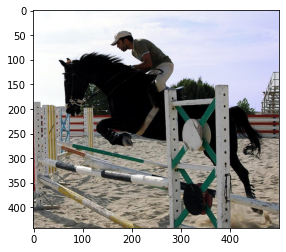

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


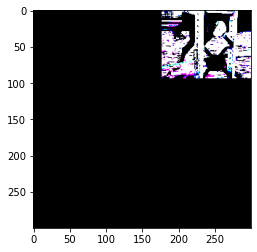

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


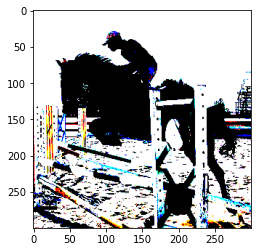

In [26]:
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

#### Dataset

In [27]:
class VOCDataset(data.Dataset):
    
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)
        return im, gt
    
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        height, width, channels = img.shape
        
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)
        
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4])
        
        img = torch.from_numpy(img[:, :, (2,1,0)]).permute(2,0,1)
        
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        return img, gt, height, width

In [28]:
color = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                           transform = DataTransform(input_size, color_mean),
                           transform_anno = Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
                         transform = DataTransform(input_size, color_mean),
                         transform_anno = Anno_xml2list(voc_classes))

val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

#### Dataloader
アノテーションの情報、変数gtのサイズ(物体数)が画像データごとに異なるため、それに対応する必要がある。

In [29]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
    
    imgs = torch.stack(imgs, dim=0)
    
    return imgs, targets

In [30]:
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

color = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                           transform = DataTransform(input_size, color_mean),
                           transform_anno = Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
                         transform = DataTransform(input_size, color_mean),
                         transform_anno = Anno_xml2list(voc_classes))

batch_size = 32

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

dataloaders_dicts = {'train':train_dataloader, 'val':val_dataloader}

#### モデルの作成

In [31]:
ssd_cfg = {
    'num_classes': 21,
    'input_size': 300,
    'bbox_aspect_num': [4,6,6,6,4,4],
    'feature_maps': [38,19,10,5,3,1],
    'steps': [8,16,32,64,100,300],
    'min_sizes': [30,60,111,162,213,264],
    'max_sizes': [60,111,162,213,264,315],
    'aspect_ratios': [[2],[2,3],[2,3],[2,3],[2],[2]]
}

net = SSD(phase='train', cfg=ssd_cfg)

vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)


使用デバイス: cpu


#### 損失関数と最適化手法

In [32]:
import torch.optim as optim

criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

#### 学習

In [33]:
import time

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)
    
    net.to(device)
    
    torch.backends.cudnn.benchmark = True
    
    iteration = 1
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    logs = []
    
    for epoch in range(num_epochs+1):
        t_epoch_start = time.time()
        t_iter_start = time.time()
        
        print('-'*20)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                print(' (train) ')
            else:
                if((epoch+1)%10==0):
                    net.eval()
                    print('-'*20)
                    print(' (val) ')
                else:
                    continue
            
            for images, targets in dataloaders_dict[phase]:
                images = images.to(device)
                targets = [ann.to(device) for ann in targets]
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(images)
                    
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c
                    
                    if phase == 'train':
                        loss.backward()
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        optimizer.step()
                        
                        if (iteration % 10 == 0):
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()
                            iteration += 1
                    else:
                        epoch_val_loss += loss.item()
        t_epoch_finish = time.time()
        print('-'*20)
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
        log_epoch = {'epoch':epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv('log_output.csv')
        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_'+str(epoch+1)+'.pth')

In [35]:
num_epochs = 2
train_model(net, dataloaders_dicts, criterion, optimizer, num_epochs=num_epochs)

使用デバイス: cpu
--------------------
Epoch 1/2
--------------------
 (train) 


C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

In [31]:
%cd C:\Users\tanak\study\参考書\pytorchによる発展ディープラーニング\pytorch_advanced-master\2_objectdetection
import os
import urllib.request
import zipfile
import tarfile

C:\Users\tanak\study\参考書\pytorchによる発展ディープラーニング\pytorch_advanced-master\2_objectdetection


In [33]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [34]:
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

In [35]:
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [36]:
url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)